# Challenge for Data Engineer position at TI

Borja González Ferreiro


In [1]:
# For having nice plots showing on the notebook
%matplotlib inline

# First exercise: count the number of lines in Python for each file

In [ ]:
bookingName = "../bookings.csv"
searchName = "../searches.csv" 

with open(bookingName, "r") as f: nbLinesBook = sum(1 for line in f)
with open(searchName, "r")  as f: nbLinesSearch = sum(1 for line in f)
    
print("Number of lines for {}: {:n} (header included)".format(bookingName, nbLinesBook))
print("Number of lines for {}: {:n} (header included)".format(searchName, nbLinesSearch))

# Second exercise: top 10 arrival airports in the world in 2013 (using the bookings file)

In [ ]:
import pandas as pd # For bonus points :)


# Since the data fits in memory, it is not necessary to process the file by chunks
# We are only going to use columns arr_port and pax, so not need to load the rest
bookings = pd.read_csv(bookingName,  sep='^', usecols=["arr_port", "pax"])# dtype={'pax':int, 'arr_port':str})

### Quick check that there are no oddities in the data such as missing values

In [ ]:
bookings.describe()

We notice that there is something off since there should be 10000010 instead of 10000009. Let's find which row contain an NaN value and remove it from our dataframe:

In [ ]:
bookings=bookings[bookings.pax.notnull()]

### top 10 arrival airports in the world in 2013

In [ ]:
groupAir = bookings[['arr_port', 'pax']].groupby('arr_port', sort=False)

numAir = 10
airTopPax=groupAir.sum().nlargest(numAir, 'pax')

In [ ]:
from GeoBases import GeoBase
geo_o = GeoBase(data='ori_por', verbose=False)

#Add column with the city corresponding to the airport
airTopPax['City'] = airTopPax.apply(lambda row: geo_o.get(row.name.strip(),'city_name_ascii'), axis=1)

# Change names of columns and index for display
airTopPax.rename(columns={ 'pax': 'Arrivals'}, inplace=True)
airTopPax.index.names = ['Airport']

print("The {} airports with more passengers are:".format(numAir))
airTopPax

# Third exercise: plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona¶

After taking a look at the data, some lines use as delimiter between fields a ','. That is why I modified the original searches file in order to have exclussively ^ as delimiter. I used the following command:
sed 's/,/\^/g' ../searches.csv > ../correctedSearches.csv

In [2]:
import pandas as pd # For bonus points :)


searchName = "../correctedSearches.csv" 

# Since the data fits in memory, it is not necessary to process the file by chunks
# We are only going to use columns Origin and Destination, so not need to load the rest
# Taking a look at the file, we notice most of the lines use ^ as field separator and only 33 lines use ,
searches = pd.read_csv(searchName,  sep='^', usecols=["Date", "Origin", "Destination"], parse_dates=['Date'], dayfirst=False, index_col='Date')

### Quick check that there are no oddities in the data such as missing values¶

In [3]:
searches.describe()

,Origin,Destination
count,20390198,20390198
unique,2503,3068
top,FRA,BKK
freq,550736,477093


We notice that the number of values for Origin and destination match the number of lines in the file (without the header).

### Plotting the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona

First, we pick only the rows associated with destinations: Madrid, Málaga and Barcelona airports. Then we group the values  by month and destination and we count the number of searches for each destination, so that finally I only have to plot them. 

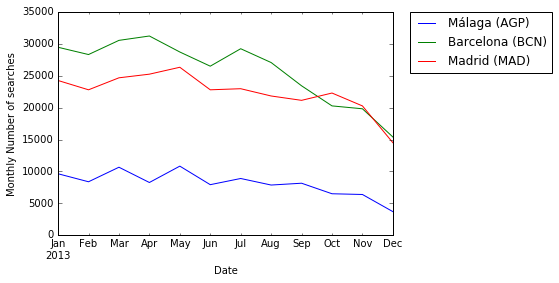

In [4]:
airSearches = searches[(searches["Destination"] == "MAD") | (searches["Destination"] == "BCN") | (searches["Destination"] == "AGP")]

monthSearches = airSearches.groupby([pd.TimeGrouper(freq='M'), "Destination"]).count()

pl=monthSearches.unstack().plot()
pl.legendlabels = ["AGP", "BCN", "MAD"]
pl.set(ylabel='Monthly Number of searches')
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=["Málaga (AGP)", "Barcelona (BCN)", "Madrid (MAD)"])